# XAI Laboratory 01 - Tabular Methods

For this practice, you will need the following dataset:

- **fifa**: regression dataset containing FIFA players data:
    - short_name: name of the player
    - nationality
    - overall: overall score of the player (potential output)
    - potential: potential score of the player (potential output)
    - wage_eur: contract cancellation fine of the player (potential output)
    - value_eur: value in euros of the player (potential output)
    - age: age of the player in years
    - height_cm: height of the player in cm
    - weight_kg: weight of the player in kg
    - attacking_skills: several variables related to attacking
    - defending_skills: several variables related to defending
    - goalkeeping_skills: several variables related to goalkeeping

Use what you have learned from the `tabular_explanation.ipynb` notebook to complete the questions.

In [41]:
# !uv pip install -r ../requirements.txt

In [42]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# XAI
import shap
import lime
from alepython import ale_plot # You might need to install from source: pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(2025)

In [59]:
### Load file --------------------------------------------
df = pd.read_csv('../data/fifa.csv')
df.head()

,short_name,nationality,overall,potential,wage_eur,value_eur,age,height_cm,weight_kg,attacking_crossing,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,Argentina,94,94,565000,95500000,32,170,72,88,...,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,Portugal,93,93,405000,58500000,34,187,83,84,...,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,Brazil,92,92,290000,105500000,27,175,68,87,...,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,Slovenia,91,93,125000,77500000,26,188,87,13,...,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,Belgium,91,91,470000,90000000,28,175,74,81,...,88,91,34,27,22,11,12,6,8,8


In [44]:
non_feature_cols = ["short_name", "nationality", "overall", "potential", "value_eur", "wage_eur"]
X = df.drop(non_feature_cols, axis = 1)
y = df['value_eur']

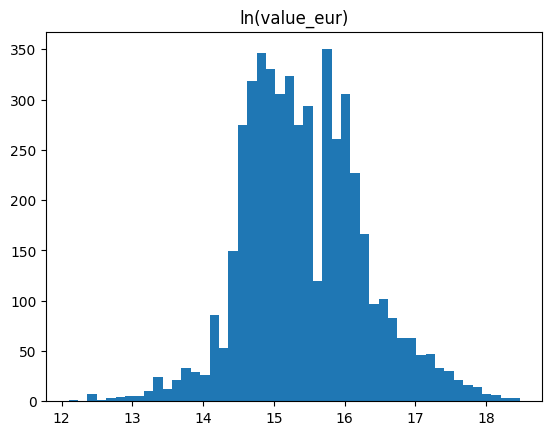

In [45]:
# Change scale of output variable
ylog = np.log(y)

plt.hist(ylog, bins='auto')
plt.title("ln(value_eur)")
plt.show()

In [46]:
X_train, X_test, ylog_train, ylog_test, y_train, y_test = train_test_split(X, ylog, y, test_size=0.25, random_state=42)

In [47]:
# Train XGBoost model, may take a few minutes
model = XGBRegressor()
model.fit(X_train, ylog_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [48]:
def predict_function(model, data):
    """Predict wrapper: original model was trained on log-output; return exp(pred) to recover original scale."""
    return np.exp(model.predict(data))

---
Ex 1. Ensure your model is not overfitted

In [49]:
from sklearn.metrics import r2_score, mean_squared_error

ylog_pred_train = model.predict(X_train)
ylog_pred_test = model.predict(X_test)

print(f"R2 train:    {r2_score(ylog_train, ylog_pred_train):.4f}")
print(f"R2 test:     {r2_score(ylog_test, ylog_pred_test):.4f}")
print(f"RMSE train:  {np.sqrt(mean_squared_error(ylog_train, ylog_pred_train)):.4f}")
print(f"RMSE test:   {np.sqrt(mean_squared_error(ylog_test, ylog_pred_test)):.4f}")

print("\nNOTE: R2 and RMSE are computed on log-scale.")

R2 train:    0.9971
R2 test:     0.9262
RMSE train:  0.0455
RMSE test:   0.2346

NOTE: R2 and RMSE are computed on log-scale.


In [50]:
import shap

explainer = shap.Explainer(model)
shap_train = explainer(X_train)
shap_test = explainer(X_test)

# Compare mean absolute SHAP values per feature
mean_train = np.abs(shap_train.values).mean(axis=0)
mean_test = np.abs(shap_test.values).mean(axis=0)

shap_values = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean |SHAP| train': mean_train,
    'Mean |SHAP| test': mean_test,
    'Ratio |SHAP| test/train': mean_test / mean_train
}).sort_values(by='Ratio |SHAP| test/train', ascending=False)
shap_values

,Feature,Mean |SHAP| train,Mean |SHAP| test,Ratio |SHAP| test/train
4,attacking_finishing,0.060492,0.063925,1.056746
16,movement_reactions,0.154201,0.162200,1.051871
12,skill_ball_control,0.155507,0.163502,1.051413
11,skill_long_passing,0.022864,0.023943,1.047187
18,power_shot_power,0.014547,0.014999,1.031103
26,mentality_vision,0.029672,0.030338,1.022473
25,mentality_positioning,0.035555,0.036298,1.020881
23,mentality_aggression,0.023462,0.023944,1.020535
19,power_jumping,0.010199,0.010402,1.019879
22,power_long_shots,0.020963,0.021273,1.014800


- The model is slightly overfitted: 
    - Small (but not nonexistent) R2 and RMSE gaps
    - SHAP: When calculating SHAP with train and test, we see the majority of SHAP train/test ratios are between 0.95 and 1.05, which shows feature importance remains consistent between train and test sets

---
Ex 2. Obtain and plot variable importance measures using the following variable groups

In [51]:
variable_groups = {
    'age': ['age'],
    'body': ['height_cm', 'weight_kg'],
    'attacking': ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys'],
    'skill': ['skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control'],
    'movement': ['movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance'],
    'power': ['power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots'],
    'mentality': ['mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties',
        'mentality_composure'],
    'defending': ['defending_marking', 'defending_standing_tackle','defending_sliding_tackle'],
    'goalkeeping' : ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
}

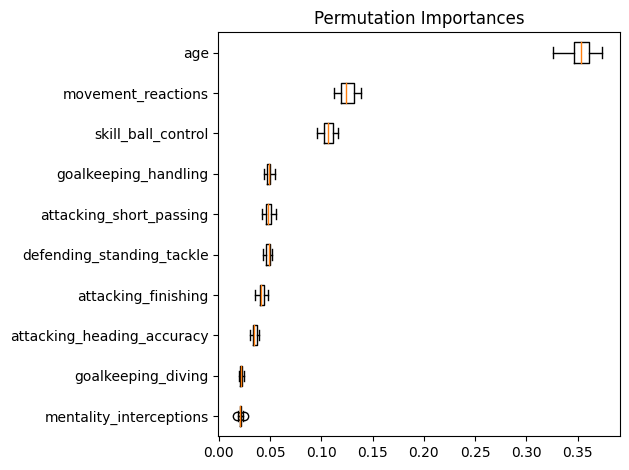

In [52]:
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(
    model, X_test, ylog_test, n_repeats=30, random_state=0
)

sorted_idx = perm_imp.importances_mean.argsort()
# Select top 10 features
sorted_idx = sorted_idx[-10:]

fig, ax = plt.subplots()
ax.boxplot(
    perm_imp.importances[sorted_idx].T,
    vert=False, labels=X_test.columns[sorted_idx]
)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

---
Ex 3. Obtain which is the variable with higher influence in Leo Messi's value. Justify which algorithm you choose

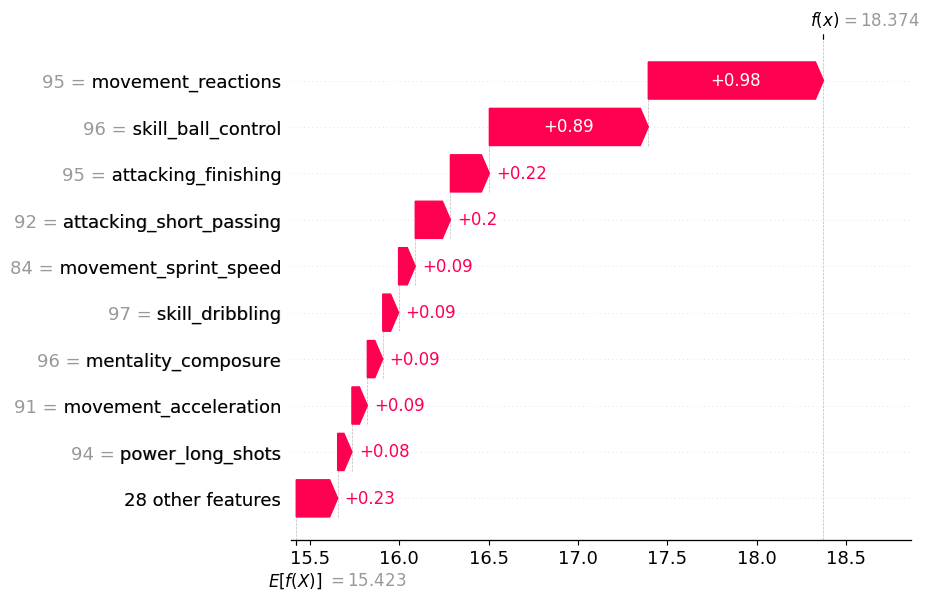

In [ ]:
player = "L. Messi"

explainer = shap.TreeExplainer(model)

messi = df[df.short_name == player]
X_messi = messi.drop(non_feature_cols, axis = 1)
shap_values_messi = explainer(X_messi)

shap.plots.waterfall(shap_values_messi[0])

> We used SHAP because it provides a local explanation for each individual prediction. SHAP decomposes the model’s output into additive contributions from each feature, allowing us to identify which variable most increased Leo Messi’s predicted market value.

---
Ex 4. Explain how perturbating the `height_cm` variable affect the value of Cristiano Ronaldo

Text(0.5, 1.0, 'Effect of perturbing height_cm on predicted value_eur for Cristiano Ronaldo')

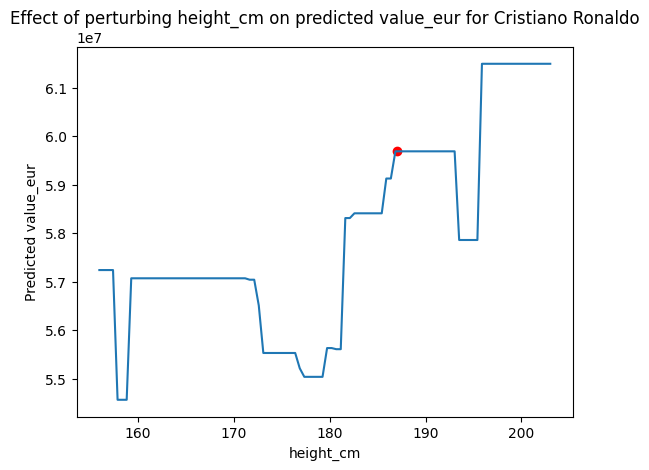

In [62]:
feature = "height_cm"
player = "Cristiano Ronaldo"

cr7 = df[df.short_name == player]
X_cr7 = cr7.drop(non_feature_cols, axis = 1)

# To see how perturbations in a certain feature affect the value, we can use a linspace around the original values
values = np.linspace(df[feature].min(), df[feature].max(), 100)
preds = []
for val in values:
    X_cr7_perturbed = X_cr7.copy()
    X_cr7_perturbed[feature] = val
    preds.append(predict_function(model, X_cr7_perturbed))

plt.plot(values, preds)
plt.scatter(X_cr7[feature], predict_function(model, X_cr7), color='red', label='Original prediction')
plt.xlabel(feature)
plt.ylabel('Predicted value_eur')
plt.title(f'Effect of perturbing {feature} on predicted value_eur for {player}')

> This plot shows how the model predicts Cristiano Ronaldo’s market value would change if we varied only his height, keeping all his other characteristics the same. Each point on the blue line represents what the model would predict if Cristiano were that tall. The red dot marks his actual height (around 187 cm) and the value the model assigns to him at that point.

> The line isn’t perfectly smooth because the model doesn’t react continuously to small height changes. Instead, as the model is tree-based, it adjusts the prediction only when the new height crosses certain thresholds that the model has learned during training.

> Overall, the model suggests that taller players tend to have slightly higher predicted market values, and Ronaldo’s actual height places him near the upper range where the value is already quite high.

---
Ex 5. Explain the average effect of the `age` variable on the model predictions. Does it differ greatly along the samples in the dataset? Which should be more affected by perturbating this variable, the goalkeepers or the strikers?

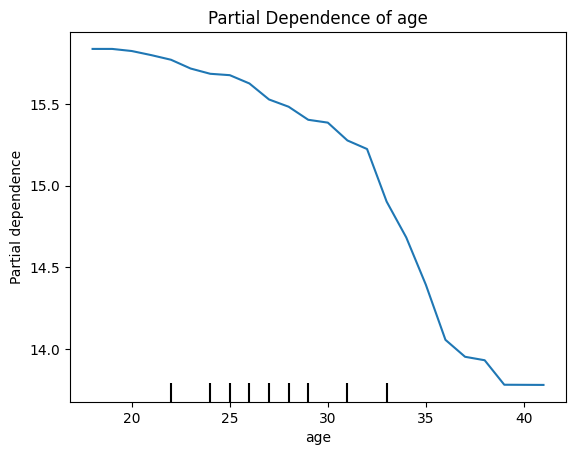

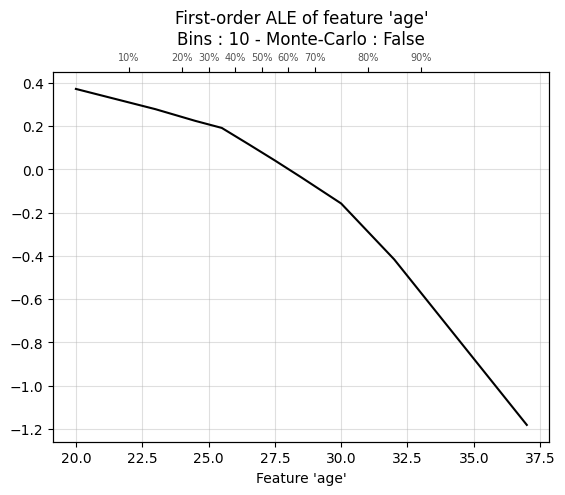

<Axes: title={'center': "First-order ALE of feature 'age'\nBins : 10 - Monte-Carlo : False"}, xlabel="Feature 'age'">

In [65]:
from sklearn.inspection import PartialDependenceDisplay

feature = "age"

# We use X_test and not X because we want to see how the model behaves on unseen data

PartialDependenceDisplay.from_estimator(
    model, X_test, [feature], kind="average"
)
plt.title(f'Partial Dependence of {feature}')
plt.show()


ale_plot(model, X_test, feature)

We used the ALE plot instead of a PDP because many features in the FIFA dataset are correlated — for example, *age* often moves together with *stamina*, *potential*, or *overall rating*. PDP assumes all features are independent, which can lead to unrealistic combinations (like a 17-year-old with world-class stats).  

ALE avoids this by calculating the average local effect of small changes in *age* only within regions of the data where such players actually exist. This makes the explanation more reliable.

> The ALE plot shows that age has a clearly negative average effect on the model’s predictions: as players get older, their predicted market value decreases steadily. Younger players (around 20–28 years old) contribute positively to the prediction, while after about 28 the effect becomes negative, meaning the model expects lower values for older players. From 30 onwards, the effect becomes very negative.

> This relationship is quite consistent across the dataset. The curve is smooth and monotonic, so the effect of age does not vary greatly between samples. The model therefore interprets age as a broadly uniform factor that reduces value for all players.

> However, the magnitude of this effect likely differs by position. Goalkeepers often maintain high performance levels later in their careers, so their value may decline more slowly with age. Strikers, on the other hand, depend more on physical attributes (speed, stamina, acceleration), which tend to deteriorate earlier; their market value is therefore more sensitive with age.

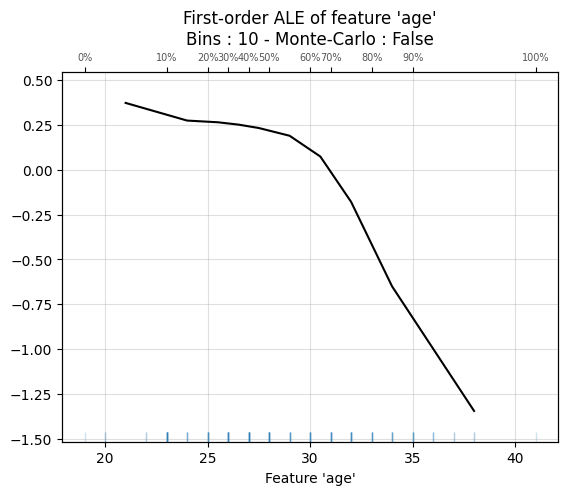

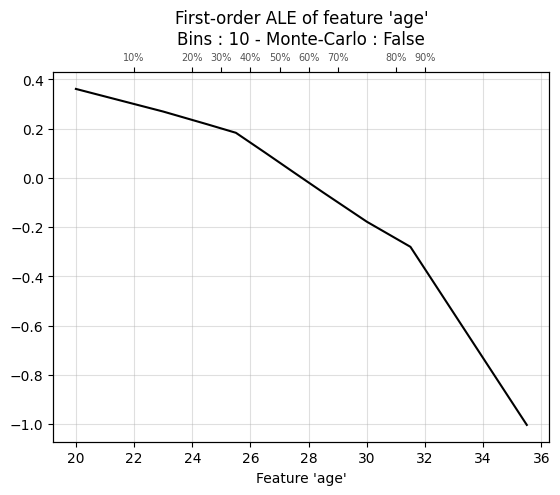

<Axes: title={'center': "First-order ALE of feature 'age'\nBins : 10 - Monte-Carlo : False"}, xlabel="Feature 'age'">

In [71]:
# Filter dataset by goalkeeping_reflexes 
gk_filter = X_test['goalkeeping_reflexes'] > 50
X_test_gk = X_test[gk_filter]
X_test_non_gk = X_test[~gk_filter]

ale_plot(model, X_test_gk, 'age')
ale_plot(model, X_test_non_gk, 'age')


As we can see, for goalkeepers, age contributes positive until 31 years old. However, for non-goalkeepers it starts contributing negatively before 28 years old

---
Ex 6. Explain the prediction made for Hazard using a local surrogate model (Lime)

In [72]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data = X_train.values,
    feature_names = X_train.columns,
    class_names = ['value_eur'],
    mode = 'regression'
)

name = "E. Hazard"

hazard = df[df.short_name == name]
X_hazard = hazard.drop(non_feature_cols, axis = 1)

exp = explainer.explain_instance(
    X_hazard.values[0], model.predict, num_features=10
)
exp.show_in_notebook(show_table=True)

> The LIME explainer builds a simple linear model around Eden Hazard’s data point to approximate how the XGBoost model behaves nearby. This allows us to identify which attributes most affected his predicted market value.

> For Hazard, the variables that increase his estimated value are mainly movement_reactions, skill_ball_control, attacking_short_passing, and attacking_finishing, all related to his attacking position. The only variable with a negative effect is defending_standing_tackle, reflecting that defensive skills matter less for an attacker like Hazard.

> Overall, the model values Hazard mainly for his offensive skills, is expected for an attacker.